In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

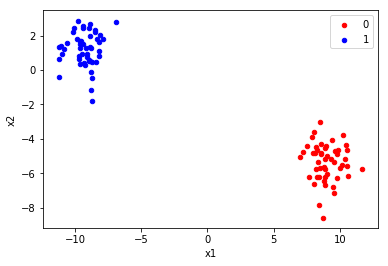

In [2]:
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
# generate 2d classification dataset
X, y = make_blobs(n_samples=100, centers=2, n_features=2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x1=X[:,0], x2=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color=colors[key])
pyplot.show()

shuffle_idx = np.arange(y.shape[0])
X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

    def forward(self, x):
        z = torch.mm(x, self.weights) + self.bias
        y_pred = torch.where(z > 0, torch.tensor([[1]]), torch.tensor([[0]])).float()
        return y_pred
        
    def backward(self, x, y):  
        y_pred = self.forward(x)
        errors = y - y_pred
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            for i in range(x.size()[0]):
                errors = self.backward(x[i].view(1, self.num_features), y[i])
                errors = errors.view(-1)
                self.weights += (errors * x[i]).view(self.num_features, 1)
                self.bias += errors
               
                
    def evaluate(self, x, y):
        y_pred = self.forward(x).view(-1)
        accuracy = torch.sum(y_pred == y).float() / x.size()[0]
        return accuracy

In [7]:
ppn = Perceptron(num_features=2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=5)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

Model parameters:
  Weights: tensor([[-9.2473],
        [ 0.3137]])
  Bias: tensor([1.])


In [8]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 100.00%
